In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, \
    MVNPrior, UVNPrior, GammaPrior

import matplotlib.pyplot as plt
%matplotlib inline

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = ModelParamsDict('Prior Parameters')

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    analysis_name = 'simulated_data_large'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    vp_base = json_dat['vp_base']

    print stan_dat.keys()
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    # Define a class to contain prior parameters.
    prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
    beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
    prior_par.push_param(PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

    prior_par.push_param(ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
    prior_par.push_param(ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

    prior_par.push_param(ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
    prior_par.push_param(ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data
    def Logistic(u):
        return np.exp(u) / (1 + np.exp(u))

    NObs = NG * N
    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0
    true_u = np.random.normal(true_mu, 1 / np.sqrt(true_tau), NG)

    x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
    y_g_vec = [ g for g in range(NG) for n in range(N) ]
    true_rho = Logistic(np.matmul(x_mat, true_beta) + true_u[y_g_vec])
    y_vec = np.random.random(NObs) < true_rho
    
    prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.zeros(K)))
    prior_par.push_param(PosDefMatrixParam('beta_prior_info', K, val=0.01 * np.eye(K)))

    prior_par.push_param(ScalarParam('mu_prior_mean', val=0))
    prior_par.push_param(ScalarParam('mu_prior_info', val=0.5))

    prior_par.push_param(ScalarParam('tau_prior_alpha', val=3.0))
    prior_par.push_param(ScalarParam('tau_prior_beta', val=10.0))

print N * NG
print np.mean(y_vec)

[u'y_group', u'mu_prior_var', u'mu_prior_t', u'mu_prior_var_c', u'K', u'beta_prior_var', u'tau_prior_beta', u'N', u'mu_prior_mean_c', u'mu_prior_epsilon', u'mu_prior_mean', u'y', u'x', u'NG', u'beta_prior_mean', u'tau_prior_alpha']
10000
0.4668


In [3]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict('GLMM Parameters')

glmm_par.push_param(UVNParam('mu', min_info=vp_base['mu_info_min'][0]))
glmm_par.push_param(GammaParam('tau',
                               min_shape=vp_base['tau_alpha_min'][0],
                               min_rate=vp_base['tau_beta_min'][0]))
glmm_par.push_param(MVNParam('beta', K, min_info=vp_base['beta_diag_min'][0]))
glmm_par.push_param(UVNParamVector('u', NG, min_info=vp_base['u_info_min'][0]))

# Initialize with ADVI.  Don't forget to add the ADVI computation time to your final VB time!
advi_init = False
if advi_init:
    advi_fit = json_dat['advi_results']
    glmm_par['mu'].mean.set(advi_fit['mu_mean'][0])
    glmm_par['mu'].info.set(1 / advi_fit['mu_var'][0])

    tau_mean = advi_fit['tau_mean'][0]
    tau_var = advi_fit['tau_var'][0]
    glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
    glmm_par['tau'].rate.set(tau_var / tau_mean)

    glmm_par['beta'].mean.set(np.array(advi_fit['beta_mean']))
    glmm_par['beta'].info.set(np.array(advi_fit['beta_info']))

    glmm_par['u'].mean.set(np.array(advi_fit['u_mean']))
    glmm_par['u'].info.set(1 / np.array(advi_fit['u_var']))

    free_par_vec = glmm_par.get_free()
else:
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
    

In [4]:
# Define moment parameters

moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_tau'))
moment_par.push_param(ScalarParam('e_log_tau'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(glmm_par, moment_par):
    moment_par['e_beta'].set(glmm_par['beta'].e())
    moment_par['e_beta_outer'].set(glmm_par['beta'].e_outer())
    moment_par['e_mu'].set(glmm_par['mu'].e())
    moment_par['e_mu2'].set(glmm_par['mu'].e_outer())
    moment_par['e_tau'].set(glmm_par['tau'].e())
    moment_par['e_log_tau'].set(glmm_par['tau'].e_log())
    moment_par['e_u'].set(glmm_par['u'].e())
    moment_par['e_u2'].set((glmm_par['u'].e_outer()))
    
set_moments(glmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [5]:
def ELogPrior(prior_par, glmm_par_elbo):
    e_beta = glmm_par_elbo['beta'].mean.get()
    info_beta = glmm_par_elbo['beta'].info.get()
    cov_beta = np.linalg.inv(info_beta)
    beta_prior_info = prior_par['beta_prior_info'].get()
    beta_prior_mean = prior_par['beta_prior_mean'].get()
    e_log_p_beta = MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta)
    
    e_mu = glmm_par_elbo['mu'].mean.get()
    info_mu = glmm_par_elbo['mu'].info.get()
    var_mu = 1 / info_mu
    e_log_p_mu = UVNPrior(prior_par['mu_prior_mean'].get(), prior_par['mu_prior_info'].get(), e_mu, var_mu) 

    e_tau = glmm_par_elbo['tau'].e()
    e_log_tau = glmm_par_elbo['tau'].e_log()
    tau_prior_shape = prior_par['tau_prior_alpha'].get()
    tau_prior_rate = prior_par['tau_prior_beta'].get()
    e_log_p_tau = GammaPrior(tau_prior_shape, tau_prior_rate, e_tau, e_log_tau)
    
    return  e_log_p_beta + e_log_p_mu + e_log_p_tau
           

def DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_u, var_u, std_draws):
    z_mean = e_u + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * z_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum(((e_mu - e_u) ** 2) + var_mu + var_u) + 0.5 * e_log_tau * len(e_u)

    
def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws, prior_par):
    e_beta = glmm_par_elbo['beta'].mean.get()
    info_beta = glmm_par_elbo['beta'].info.get()
    cov_beta = np.linalg.inv(info_beta)
    
    e_u = glmm_par_elbo['u'].mean.get()
    info_u = glmm_par_elbo['u'].info.get()
    var_u = 1 / info_u
    
    e_mu = glmm_par_elbo['mu'].mean.get()
    info_mu = glmm_par_elbo['mu'].info.get()
    var_mu = 1 / info_mu
    
    e_tau = glmm_par_elbo['tau'].e()
    e_log_tau = glmm_par_elbo['tau'].e_log()
        
    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau)
    if np.isnan(ll):
        return -np.inf

    e_log_prior = ELogPrior(prior_par, glmm_par_elbo)
    if np.isnan(e_log_prior):
        return -np.inf
    
    tau_shape = glmm_par_elbo['tau'].shape.get()
    tau_rate = glmm_par_elbo['tau'].rate.get()
    entropy = \
        UnivariateNormalEntropy(info_mu) + \
        MultivariateNormalEntropy(info_beta) + \
        UnivariateNormalEntropy(info_u) + \
        GammaEntropy(tau_shape, tau_rate)

    return ll[0] + e_log_prior[0] + entropy


class KLWrapper(object):
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.set_draws(num_draws)
        
    def set_draws(self, num_draws):
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)

    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, self.std_draws, self.__prior_par_ad)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl
    
    def ExpectedLogPrior(self, free_par_vec, prior_par_vec):
        # Encode the glmm parameters first and the prior second.
        self.__glmm_par_ad.set_free(free_par_vec)
        self.__prior_par_ad.set_vector(prior_par_vec)
        e_log_prior = ELogPrior(self.__prior_par_ad, self.__glmm_par_ad)
        return e_log_prior[0]
        
        
class MomentWrapper(object):
    def __init__(self, glmm_par, moment_par):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par


kl_wrapper = KLWrapper(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
print kl_wrapper.Eval(free_par_vec)

moment_wrapper = MomentWrapper(glmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)

# PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
PriorModelGrad = grad(kl_wrapper.ExpectedLogPrior, argnum=0)
PriorHess = jacobian(PriorModelGrad, argnum=1)

kl_wrapper.ExpectedLogPrior(free_par_vec, prior_par.get_vector())


14516.0995561


-3.6657256909229563

In [6]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

Function time:
0.0236967086792
Grad time:
0.0572127103806
Hessian vector product time:
0.112129306793


In [7]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_draws):
    kl_wrapper.set_draws(num_draws)
    vb_opt = optimize.minimize(
        lambda par: kl_wrapper.Eval(par, verbose=True),
        trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
        tol=1e-6, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [8]:
import time

init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
num_mc_draws = 50

print 'Running Newton Trust Region'
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_mc_draws)
vb_time = time.time() - vb_time

print 'Done.'

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
set_moments(glmm_par_opt, moment_par)

print vb_time / 60

Running Newton Trust Region
16320.689584
9038.30934811
5009.20455721
3813.34808885
3003.48432409
2392.18151882
2308.02385314
1937.79661974
1914.25804238
1766.0002339
1763.67259786
1694.19685044
1693.44038432
1688.44471877
1687.5955049
1686.48239351
1686.40448757
1686.32247727
1686.17676412
1686.17419633
1686.16570804
1686.16524403
1686.16519242
1686.16519235
Optimization terminated successfully.
         Current function value: 1686.165192
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
         Hessian evaluations: 0
Done.
0.978202748299


In [9]:
if False:
    # Investigate the performance of different numbers of draws.   It doesn't appear to
    # converge.
    opt_x_20 = tr_optimize(init_par_vec, 20)
    opt_x_60 = tr_optimize(opt_x_20, 60)
    opt_x_100 = tr_optimize(opt_x_60, 100)
    opt_x_200 = tr_optimize(opt_x_100, 200)
    opt_x_400 = tr_optimize(opt_x_200, 400)
    opt_x_800 = tr_optimize(opt_x_400, 800)
    
    mom_20 = get_moment_vec(opt_x_20)
    mom_60 = get_moment_vec(opt_x_60)
    mom_100 = get_moment_vec(opt_x_100)
    mom_200 = get_moment_vec(opt_x_200)
    mom_400 = get_moment_vec(opt_x_400)
    mom_800 = get_moment_vec(opt_x_800)

    print np.max(np.abs((mom_20 - mom_60) / mom_20))
    print np.max(np.abs((mom_60 - mom_100) / mom_60))
    print np.max(np.abs((mom_100 - mom_200) / mom_100))
    print np.max(np.abs((mom_200 - mom_400) / mom_200))
    print np.max(np.abs((mom_400 - mom_800) / mom_400))

    print '-------\n'
    print np.max(np.abs((mom_20 - mom_60)))
    print np.max(np.abs((mom_60 - mom_100)))
    print np.max(np.abs((mom_100 - mom_200)))
    print np.max(np.abs((mom_200 - mom_400)))
    print np.max(np.abs((mom_400 - mom_800)))

    #diff_inds = np.where(np.abs(mom_60 - mom_100) > 1e-2)
    #print diff_inds
    #print moment_indices

    #print (get_moment_vec(opt_x_60) - get_moment_vec(opt_x_100)) / np.abs(get_moment_vec(opt_x_100))
    get_moment_vec(opt_x_200)
    u200 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_400)
    u400 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_800)
    u800 = copy.deepcopy(moment_par['e_u'].get())


-24072.6486679
-24091.4677665
0.00937548974616
(array([   1,    3,    6, ..., 9994, 9998, 9999]),)
0.495732316683
0.503175450209


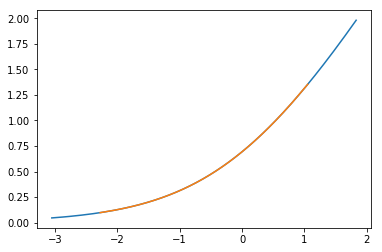

In [10]:
# Examine why the means are different for different number of simulations.
def get_logit_terms(num_draws):
    kl_wrapper.set_draws(num_draws)
    std_draws = kl_wrapper.std_draws

    e_beta = glmm_par_opt['beta'].mean.get()
    info_beta = glmm_par_opt['beta'].info.get()
    cov_beta = np.linalg.inv(info_beta)

    e_u = glmm_par_opt['u'].mean.get()[y_g_vec]
    info_u = glmm_par_opt['u'].info.get()[y_g_vec]
    var_u = 1 / info_u

    z_mean = e_u + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_terms = np.log1p(np.exp(z))
    logit_term = -np.sum(logit_terms) / std_draws.size

    return logit_term, logit_terms, z
    
logit_term_50, logit_terms_50, z_50 = get_logit_terms(50)    
logit_term_800, logit_terms_800, z_800 = get_logit_terms(800)

print logit_term_50
print logit_term_800

logit_terms_50_mean = np.mean(logit_terms_50, 1)
logit_terms_800_mean = np.mean(logit_terms_800, 1)

print np.max(np.abs(logit_terms_50_mean - logit_terms_800_mean))
print np.where(np.abs(logit_terms_50_mean - logit_terms_800_mean) > 1e-3)

ind = 3
plt.plot(z_800[ind, :], logit_terms_800[ind, :])
plt.plot(z_50[ind, :], logit_terms_50[ind, :])
print logit_terms_50_mean[ind]
print logit_terms_800_mean[ind]


In [11]:
# Get the Hessians at the number of draws used for optimization.

kl_wrapper.set_draws(num_mc_draws)

hess_time = time.time()
print 'KL Hessian:\n'
kl_hess = KLHess(opt_x)

print 'Log prior Hessian:\n'
log_prior_hess = PriorHess(opt_x, prior_par.get_vector())

hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print 'hess_time: %f' % hess_time

KL Hessian:

Log prior Hessian:

hess_time: 96.953184


In [12]:
moment_jac = MomentJacobian(opt_x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [13]:
if not simulate_data:
    run_name = 'production'
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                    'vb_time': vb_time, 'hess_time': hess_time, 'num_mc_draws': num_mc_draws, 
                    'moment_indices': moment_indices.dictval(),
                    'prior_indices': prior_indices.dictval(),
                    'vp_indices': vp_indices.dictval(),
                    'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                    'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

    result_json = json.dumps(result_dict)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()

    print(json_output_filename)

/home/rgiordan/Documents/git_repos/LRVBLogitGLMM/LogitGLMMLRVB/inst/data/simulated_data_large_python_vb_results.json
